In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.utils import gen_batches
from sklearn.metrics import classification_report, confusion_matrix
from typing import *
from numpy.linalg import *

train_image_file = './mnist/train-images-idx3-ubyte'
train_label_file = './mnist/train-labels-idx1-ubyte'
test_image_file = './mnist/t10k-images-idx3-ubyte'
test_label_file = './mnist/t10k-labels-idx1-ubyte'


def decode_image(path):
    with open(path, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(-1, 784)
        images = np.array(images, dtype = float)
    return images

def decode_label(path):
    with open(path, 'rb') as f:
        magic, n = struct.unpack('>II',f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
        labels = np.array(labels, dtype = float)
    return labels

def load_data():
    train_X = decode_image(train_image_file)
    train_Y = decode_label(train_label_file)
    test_X = decode_image(test_image_file)
    test_Y = decode_label(test_label_file)
    return (train_X, train_Y, test_X, test_Y)

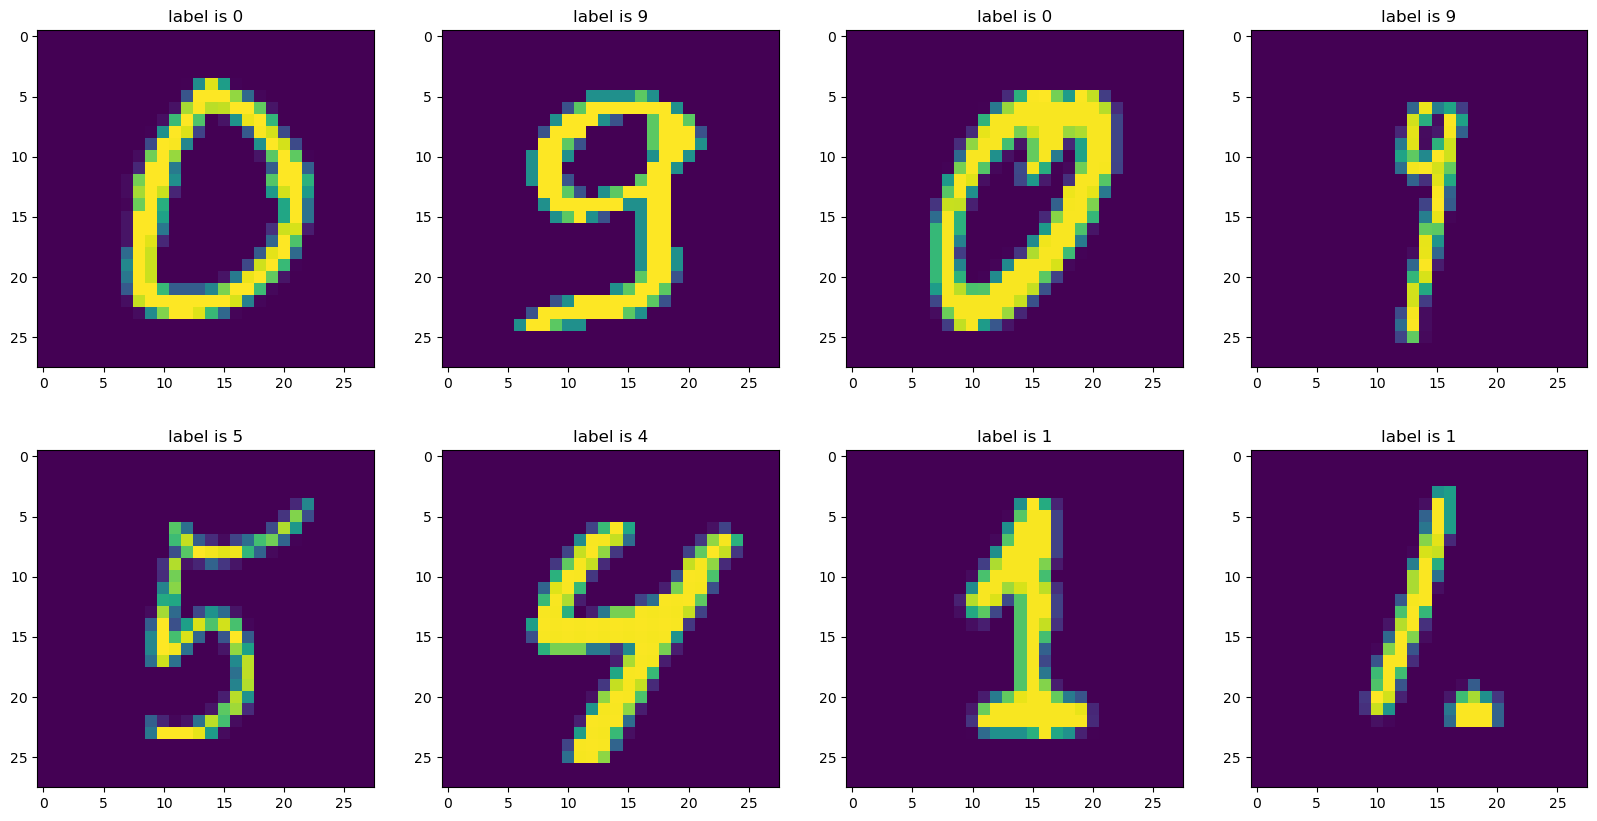

In [2]:
trainX, trainY, testX, testY = load_data()

num_train, num_feature = trainX.shape
plt.figure(1, figsize=(20,10))
for i in range(8):
    idx = np.random.choice(range(num_train))
    plt.subplot(int('24'+str(i+1)))
    plt.imshow(trainX[idx,:].reshape((28,28)))
    plt.title('label is %d'%trainY[idx])
plt.show()

In [3]:
# normalize the input value to make it between 0 and 1.
trainX, testX = trainX/255, testX/255

# convert labels to one-hot vector.
def to_onehot(y):
    y = y.astype(int)
    num_class = len(set(y))
    Y = np.eye((num_class))
    return Y[y]

trainY = to_onehot(trainY)
testY = to_onehot(testY)
num_train, num_feature = trainX.shape
num_test, _ = testX.shape
_, num_class = trainY.shape
print('number of features is %d'%num_feature)
print('number of classes is %d'%num_class)
print('number of training samples is %d'%num_train)
print('number of testing samples is %d'%num_test)
print('shape of training data is ' + str(trainX.shape))
print('shape of training data label is ' + str(trainX.shape))
print('shape of testing data is ' + str(testX.shape))
print('shape of testing data label is ' + str(testX.shape) )

number of features is 784
number of classes is 10
number of training samples is 60000
number of testing samples is 10000
shape of training data is (60000, 784)
shape of training data label is (60000, 784)
shape of testing data is (10000, 784)
shape of testing data label is (10000, 784)


In [10]:
from abc import ABC, abstractmethod, abstractproperty

class Activation(ABC):
    '''
    An abstract class that implements an activation function
    '''
    @abstractmethod
    def value(self, x: np.ndarray) -> np.ndarray:
        '''
        Value of the activation function when input is x.
        Parameters:
          x is an input to the activation function.
        Returns: 
          Value of the activation function. The shape of the return is the same as that of x.
        '''
        return x
    @abstractmethod
    def derivative(self, x: np.ndarray) -> np.ndarray:
        '''
        Derivative of the activation function with input x.
        Parameters:
          x is the input to activation function
        Returns: 
          Derivative of the activation function w.r.t x.
        '''
        return x

class Identity(Activation):
    '''
    Identity activation function. Input and output are identical. 
    '''

    def __init__(self):
        super(Identity, self).__init__()

    def value(self, x: np.ndarray) -> np.ndarray:
        return x
    
    def derivative(self, x: np.ndarray) -> np.ndarray:
        n, m = x.shape
        return np.ones((n, m))
    

class Sigmoid(Activation):
    '''
    Sigmoid activation function y = 1/(1 + e^(x*k)), where k is the parameter of the sigmoid function 
    '''

    def __init__(self):
        '''
        Parameters:
          there are no parameters.
        '''
        super(Sigmoid, self).__init__()

    def value(self, x: np.ndarray) -> np.ndarray:
      # x is a two dimensional numpy array
      # return a two dimensional array representing the element-wise sigmoid of x
      # sigmoid(x) = 1 / (1 + exp(-x))
      # use numpy's clip and exponential functions
        x = np.clip(x, -500, 500) # clip x to [-500, 500] to avoid overflow
        return 1 / (1 + np.exp(-x)) # compute the element-wise sigmoid value


    def derivative(self, x: np.ndarray) -> np.ndarray:
      # x is a two dimensional array
      # return a two dimensional array whose shape is the same as that of x
      # the returned value is the elementwise derivative of the sigmoid function w.r.t. x
      # sigmoid'(x) = sigmoid(x) * (1 - sigmoid(x))
      # use numpy's clip, exponential and multiplication functions
        x = np.clip(x, -500, 500) # clip x to [-500, 500] to avoid overflow
        s = 1 / (1 + np.exp(-x)) # compute the element-wise sigmoid value
        return s * (1 - s) # compute the element-wise sigmoid derivative value

    
class ReLU(Activation):
    '''
    Rectified linear unit activation function
    '''

    def __init__(self):
        super(ReLU, self).__init__()

    def value(self, x: np.ndarray) -> np.ndarray:
        #### write your code below ####
        
        return np.maximum(0, x)

    def derivative(self, x: np.ndarray) -> np.ndarray:
      # x is a two dimensional array
      # return the elementwise derivative of ReLU, which is the same shape as x
      # ReLU(x) = max(0, x)
      # ReLU'(x) = 1 if x > 0, 0 if x < 0, 0 if x = 0
      # use numpy's where function to assign values based on conditions
        return np.where(x > 0, 1, 0) # return 1 if x > 0, 0 otherwise



class Softmax(Activation):
    '''
    softmax nonlinear function.
    '''

    def __init__(self):
        '''
        There are no parameters in softmax function.
        '''
        super(Softmax, self).__init__()

    def value(self, x: np.ndarray) -> np.ndarray:
        # subtract the maximum of each row from each element to avoid numerical overflow
        x = x - np.max(x, axis=1, keepdims=True)
        # compute the exponential of each element
        exp_x = np.exp(x)
        # compute the sum of exponential of each row
        sum_exp_x = np.sum(exp_x, axis=1, keepdims=True)
        # divide each element by the sum of its row
        return exp_x / sum_exp_x

    def derivative(self, x: np.ndarray) -> np.ndarray:
      # x is the input to the softmax function, which is a two dimensional numpy array
      # return a two dimensional array representing the derivative of softmax function w.r.t. x
      # softmax(x) = exp(x) / sum(exp(x), axis = 1, keepdims = True)
      # softmax'(x) = softmax(x) * (1 - softmax(x))
      # use numpy's clip, exponential, sum and multiplication functions
        x = np.clip(x, -500, 500) # clip x to [-500, 500] to avoid overflow
        s = np.exp(x) / np.sum(np.exp(x), axis = 1, keepdims = True) # compute the softmax value
        return s * (1 - s) # compute the softmax derivative value


For neural network for multi-class classification, the last layer is usually a softmax activation function. The output of the softmax function together with true targets or labels are used to compute the loss function. If both the softmax function and the loss function are computed independently, there are at least one drawbacks:

> The derivative of the softmax function w.r.t. the input is a matrix, which is not like the elementwise derivative in ReLU or sigmoid. A batch of such derivatives forms a three dimensional tensor, making the computation complicated.

To mitigate such an issue, a common trick is to merge the computation of softmax function with the loss function. In other words, the inputs to the loss function is the input to the softmax other than its output. In deep learning community, often the input to the softmax is regarded as unnormalized probability and is called logits. Being called logits is not exactly correct in math but is widely used. Let $\boldsymbol{z}$ be the logits, the output of the softmax function $\hat{\boldsymbol{y}}$ is defined as

$\hat{y}_i = \frac{e^{z_i}}{\sum_{j=1}^ke^{z_j}}, i = 1, \cdots, k$

the cross entropy loss is computed as follows:

$L(\boldsymbol{z}, \boldsymbol{y}) = \sum_{i=1}^k y_i\log(\hat{y}_i) = \sum_{i=1}^k y_i\log\left(\frac{e^{z_i}}{\sum_{j=1}^ke^{z_j}}\right) = \sum_{i=1}^k y_i z_i - \sum_{i=1}^k y_i\log(\sum_{j=1}^ke^{z_j})= \sum_{i=1}^k y_i z_i - \log(\sum_{j=1}^ke^{z_j})$

In the above expression, there is a log-sum-exponential term, which often appears in research papers and text book. The reason people prefer the log-sum-exponential term is that it is easy to deal with overflow problem. For instance, there is

$L(\boldsymbol{z}, \boldsymbol{y}) = \sum_{i=1}^k y_i z_i - \log(\sum_{j=1}^ke^{z_j}) = \sum_{i=1}^k y_i z_i - \log(\sum_{j=1}^ke^{\beta}e^{-\beta}e^{z_j})= \sum_{i=1}^k y_i z_i -\beta - \log(\sum_{j=1}^ke^{z_j-\beta})$

By letting $\beta = \max z_i$, exponential terms in the exponential expression are all negative, avoiding the overflow problem.

The derivative of the above loss function is computed as follows:

$\frac{\partial L}{\partial z_i} = y_i - \frac{e^{z_i}}{\sum_{j=1}^k e^{z_j}}$
, where the expression $\frac{e^{z_i}}{\sum_{j=1}^k e^{z_j}}$ is exactly the $i$th output of the softmax function. Thus,

$\frac{\partial L}{\partial \boldsymbol{z}} = \boldsymbol{y} - \text{softmax}(\boldsymbol{z})$

In [11]:
class Loss(ABC):
    @abstractmethod
    def value(self, yhat: np.ndarray, y: np.ndarray) -> float:
        return 0

    @abstractmethod
    def derivative(self, yhat: np.ndarray, y: np.ndarray) -> np.ndarray:
        return yhat

class CrossEntropy(Loss):
    def value(self, yhat: np.ndarray, y: np.ndarray) -> float:
        eps = 1e-12
        yhat = np.clip(yhat, eps, 1 - eps)
        nll = -np.sum(y * np.log(yhat), axis=1)
        return np.mean(nll)

    def derivative(self, yhat: np.ndarray, y: np.ndarray) -> np.ndarray:
        eps = 1e-12
        yhat = np.clip(yhat, eps, 1 - eps)
        d_nll = -y / yhat
        return d_nll / len(y)
    
class CEwithLogit(Loss):
    def __init__(self):
        super(CEwithLogit, self).__init__() # add this line
    def value(self, logits: np.ndarray, y: np.ndarray) -> float:
        logits = logits - np.max(logits, axis=1, keepdims=True)
        softmax = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
        ce = CrossEntropy()
        return ce.value(softmax, y)

    def derivative(self, logits: np.ndarray, y: np.ndarray) -> np.ndarray:
        logits = logits - np.max(logits, axis=1, keepdims=True)
        softmax = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
        return softmax - y

In [12]:
def accuracy(y_hat: np.ndarray, y: np.ndarray) -> float:
    y_pred = np.argmax(y_hat, axis=1)
    y_true = np.argmax(y, axis=1)
    correct = np.sum(y_pred == y_true)
    accuracy = correct / len(y_pred)
    return accuracy

In [19]:
# This is a code block
class NeuralNetwork():
    def __init__(self, layers, activations, loss, learning_rate):
        # initialize the attributes of the class
        self.layers = layers # a list of integers representing the number of units in each layer
        self.num_layer = len(layers)
        self.activations = activations # a list of activation objects
        self.loss = loss # a loss object
        self.learning_rate = learning_rate # a scalar value
        self.W = []
        self.b = []
        # use a for loop to create and append the weight matrices
        for i in range(self.num_layer-1):
            # initialize the weight matrices with random values
            W = np.random.randn(self.layers[i], self.layers[i+1])
            b = np.random.randn(1, layers[i+1])
            self.W.append(W)
            self.b.append(b)
        self.A = []
        self.Z = []


    def forward(self, X: np.ndarray) -> (List[np.ndarray], List[np.ndarray]):
        num_sample = X.shape[0]
        A, Z = [], []
        A_prev = X
        A.append(X)
        for i in range(self.num_layer - 1):
            Z_curr = np.dot(A_prev, self.W[i]) + self.b[i]
            Z.append(Z_curr)
            A_curr = self.activations[i].value(Z_curr) # use self.activations instead of self.activation
            A.append(A_curr)
            A_prev = A_curr
        self.A = A
        self.Z = Z
        return Z, A

    def backward(self, dLdyhat) -> List[np.ndarray]:
        dZ = []
        dA_prev = dLdyhat
        for i in reversed(range(self.num_layer - 1)):
            dZ_curr = dA_prev * self.activations[i].derivative(self.Z[i]) # use self.activations instead of self.activation
            dZ.insert(0, dZ_curr)
            dA_prev = np.dot(dZ_curr, self.W[i].T)
        self.dZ = dZ
        return dZ


    def update_weights(self) -> List[np.ndarray]:
        for i in range(self.num_layer - 1):
            # use self.A[i] instead of self.A[i-1] to compute the gradient of the weights
            dLdW = np.dot(self.A[i].T, self.dZ[i]) / self.A[i].shape[0]
            dLdb = np.sum(self.dZ[i], axis=0, keepdims=True) / self.A[i].shape[0]
            self.W[i] = self.W[i] - self.learning_rate * dLdW
            self.b[i] = self.b[i] - self.learning_rate * dLdb
        return self.W

    def one_epoch(self, X: np.ndarray,  Y: np.ndarray, batch_size: int, train: bool = True)-> (float, float):
        n = X.shape[0]
        slices = list(gen_batches(n, batch_size))
        num_batch = len(slices)
        idx = list(range(n))
        np.random.shuffle(idx)
        loss_value, acc_value = 0, 0
        for i, index in enumerate(slices):
            index = idx[slices[i]]
            x, y = X[index,:], Y[index]
            # use self.forward(x) instead of model.forward(x) to execute the forward pass
            Z, A = self.forward(x)   
            yhat = A[-1]
            if train:
                dLdz = self.loss.derivative(Z[-1], y)         # Calculate derivative of the loss with respect to out
                self.backward(dLdz)     # Execute the backward pass to compute the deltas
                self.update_weights()  # Calculate the gradients and update the weights
            loss_value += self.loss.value(yhat, y)*x.shape[0]
            acc_value += accuracy(yhat, y)*x.shape[0]
        loss_value = loss_value/n
        acc_value = acc_value/n
        return loss_value, acc_value


In [20]:
def train(model : NeuralNetwork, X: np.ndarray, Y: np.ndarray, batch_size: int, epoches: int) -> (List[np.ndarray], List[float]):
    '''
    trains the neural network.
    Parameters:
      model is a NeuralNetwork object.
      X is the data input. X is a two dimensional numpy array.
      Y is the data label. Y is a one dimensional numpy array.
      batch_size is the number of samples in each batch.
      epoches is an integer, representing the number of epoches.
    Returns:
      epoch_loss is a list of float numbers, representing loss function value in all epoches.
      epoch_acc is a list of float numbers, representing the accuracies in all epoches.
    '''
    loss_value, acc = model.one_epoch(X, Y, batch_size, train = False)
    epoch_loss, epoch_acc = [loss_value], [acc]
    print('Initialization: ', 'loss %.4f  '%loss_value, 'accuracy %.2f'%acc)
    for epoch in range(epoches):
        if epoch%100 == 0 and epoch > 0: # decrease the learning rate
            model.learning_rate = min(model.learning_rate/10, 1.0e-5)
        loss_value, acc = model.one_epoch(X, Y, batch_size, train = True)
        if epoch%1 == 0:
            print("Epoch {}/{}: Loss={}, Accuracy={}".format(epoch, epoches, loss_value, acc))
        epoch_loss.append(loss_value)
        epoch_acc.append(acc)
    return epoch_loss, epoch_acc


In [23]:
# training procedure
num_sample, num_feature = trainX.shape
epoches = 5
batch_size = 512
Loss = []
Acc = []
learning_rate = 1/num_sample*batch_size
np.random.seed(2023)
model = NeuralNetwork([784, 256, 64, 10], [Identity(), ReLU(), ReLU(), Softmax()], CEwithLogit(), learning_rate = learning_rate)
epoch_loss, epoch_acc = train(model, trainX, trainY, batch_size, epoches)

# testing procedure
test_loss, test_acc = model.one_epoch(testX, testY, batch_size, train = False)
z, yhat = model.forward(testX)
yhat = np.argmax(yhat, axis = 1)
y = np.argmax(testY, axis = 1)
print(confusion_matrix(yhat, y))
print(classification_report(yhat, y))

Initialization:  loss 24.4472   accuracy 0.11
Epoch 0/5: Loss=2.98788320002132, Accuracy=0.10441666666666667
Epoch 1/5: Loss=2.3320212736733565, Accuracy=0.0997
Epoch 2/5: Loss=2.3162891060599806, Accuracy=0.0993
Epoch 3/5: Loss=2.311450467058155, Accuracy=0.09913333333333334
Epoch 4/5: Loss=2.3090884487158765, Accuracy=0.09905
[[ 980 1134 1032 1010  981  892  958 1025  974 1009]
 [   0    0    0    0    0    0    0    1    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    1    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    1    0    0    1    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    1    0    0]]
              precision    recall  f1-score   support

           0       1.00      0.10      0.18      9995
           1       0.00      0